# Import

In [1]:
import seaborn as sns
sns.set()
sns.set_style(style='white') 
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib
import os
import numpy as np
from scipy import linalg
import pandas
import time 

In [3]:
from pyiron_atomistics import Project
from pyiron_dft_uncertainty import pot_dict, \
    find_recommended_encut, \
    lattice_constants_for_element_ase, \
    get_alat_range, \
    calc_set_of_jobs, \
    setup_pyiron_table, \
    get_potential_encut, \
    get_column_from_df, \
    calc_v0_from_fit_funct, \
    bulk_modulus_from_fit_and_volume, \
    bulk_modulus_dereivative_from_fit_and_volume, \
    double_smooth, \
    shift_lst

In [4]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)

## User Parameters 

In [5]:
element = "Cu"
vol_eq_pre = 11.8405  # magic number 

In [6]:
uncertainty_parameter = {
    # Element settings 
    'element': element,
    # 'pseudo_potential': 'Cu_sv_GW',
    'pseudo_potential': None,
    'crystal_structure': None,
    'alat_guess': None,
    
    # DFT convergence settings 
    'encut_start': None,
    'encut_step': 200,
    'kpoint_start': 11,
    'kpoint_step': 20,
    'electronic_convergence': 1e-9,
    
    # Energy volume curve settings 
    'points': 21,
    'vol_range': 0.1,
    
    # pre sampling settings 
    'points_pre': 11,
    'vol_range_pre': 0.2,
    
    # Server configuration 
    'queue': 's_cmfe',
    'cores': 10, 
    'run_time': 20000, 
    'memory_factor': 4,
    'project_name': None,
}

## Fill up empty parameters

In [7]:
if uncertainty_parameter['points_pre'] is None:
    uncertainty_parameter['points_pre'] = uncertainty_parameter['points']
if uncertainty_parameter['vol_range_pre'] is None:
    uncertainty_parameter['vol_range_pre'] = uncertainty_parameter['vol_range']

In [8]:
if uncertainty_parameter['pseudo_potential'] is None:
    uncertainty_parameter['pseudo_potential'] = pot_dict[uncertainty_parameter['element']]
uncertainty_parameter['pseudo_potential']

'Cu_sv_GW'

In [9]:
if uncertainty_parameter['encut_start'] is None:
    uncertainty_parameter['encut_start'] = find_recommended_encut(
        element=None, 
        element_str=uncertainty_parameter['pseudo_potential'], 
        xc='pbe'
    )
uncertainty_parameter['encut_start']

467

In [10]:
if uncertainty_parameter['project_name'] is None:
    uncertainty_parameter['project_name'] = uncertainty_parameter['pseudo_potential']

In [11]:
crystalstructure, alat_base = lattice_constants_for_element_ase(
    element=uncertainty_parameter['element']
)
if uncertainty_parameter['crystal_structure'] is None:
    uncertainty_parameter['crystal_structure'] = crystalstructure
if uncertainty_parameter['alat_guess'] is None:
    if not (uncertainty_parameter['crystal_structure'] == crystalstructure.lower()): 
        if crystalstructure.lower() == 'bcc':
            alat_base = np.sqrt(3) / np.sqrt(2) * alat_base
        elif crystalstructure.lower() == 'hcp':
            if enforce_crystal_structure.lower() == 'fcc':
                alat_base = np.sqrt(2) * alat_base
            else:
                alat_base = np.sqrt(5) / np.sqrt(4) * alat_base
        else:
            alat_base = np.sqrt(2) / np.sqrt(3) * alat_base
    uncertainty_parameter['alat_guess'] = alat_base
uncertainty_parameter['crystal_structure'], uncertainty_parameter['alat_guess']

('fcc', 3.61)

# Data generation

In [12]:
pr = Project('Cu_sv_GW')  # This has to be updated 

In [13]:
encut_space = np.linspace(200, 1200, 51)
encut_space

array([ 200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,  360.,
        380.,  400.,  420.,  440.,  460.,  480.,  500.,  520.,  540.,
        560.,  580.,  600.,  620.,  640.,  660.,  680.,  700.,  720.,
        740.,  760.,  780.,  800.,  820.,  840.,  860.,  880.,  900.,
        920.,  940.,  960.,  980., 1000., 1020., 1040., 1060., 1080.,
       1100., 1120., 1140., 1160., 1180., 1200.])

In [14]:
kpoint_space = np.linspace(11, 91, 41)  # This has to be updated 
kpoint_space

array([11., 13., 15., 17., 19., 21., 23., 25., 27., 29., 31., 33., 35.,
       37., 39., 41., 43., 45., 47., 49., 51., 53., 55., 57., 59., 61.,
       63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83., 85., 87.,
       89., 91.])

In [15]:
cores = 8 # compute cores  
memory_factor = 2 # x-times 3GB memory 
queue = 's_cmfe'

In [16]:
structure_base = pr.create_ase_bulk(element)

In [17]:
alat_space = get_alat_range(
    vol_eq=vol_eq_pre, 
    strain=0.1, 
    steps=21, 
    crystal_structure="fcc", 
    number_of_atoms=len(structure_base)
) 
alat_space

array([3.49320587, 3.50528854, 3.51737121, 3.52945387, 3.54153654,
       3.55361921, 3.56570188, 3.57778455, 3.58986722, 3.60194989,
       3.61403256, 3.62611523, 3.6381979 , 3.65028056, 3.66236323,
       3.6744459 , 3.68652857, 3.69861124, 3.71069391, 3.72277658,
       3.73485925])

In [18]:
parameter_lst = []
for kpoints in kpoint_space:
    for encut in encut_space:
        for alat in alat_space:
            parameter_lst.append([alat, encut, kpoints])

In [19]:
sleep_period=30
iteration=10000

In [20]:
df_file_name = "pyiron/data/Cu/" + uncertainty_parameter['project_name'].lower() + ".csv"
if not os.path.exists(df_file_name):
    calc_set_of_jobs(
        pr=pr, 
        parameter_lst=parameter_lst, 
        uncertainty_parameter=uncertainty_parameter, 
        sleep_period=sleep_period, 
        iteration=iteration
    )
    pytab = setup_pyiron_table(project=pr)
    df_tmp = pytab.get_dataframe()
    df_tmp.to_csv(df_file_name)
calc_df = pandas.read_csv(df_file_name, index_col=0)

In [21]:
encut_recommended = get_potential_encut(
    el=uncertainty_parameter['pseudo_potential'].split("_")[0], 
    default_potential=uncertainty_parameter['pseudo_potential']
)
ind_select = encut_recommended < encut_space
encut_min = np.min(np.arange(len(encut_space))[ind_select])
encut_space[encut_min], encut_recommended

(400.0, 391.688)

In [22]:
vol_space = [
    pr.create_ase_bulk(element, a=alat).get_volume() 
    for alat in alat_space
]

In [23]:
eng_store_lst = []
for encut in encut_space:
    for kpoint in kpoint_space:
        vol_lst, eng_lst, conv_lst, n_kpts_lst, avg_plane_waves_lst = zip(*[
            [
                get_column_from_df(df=calc_df, column='volume', kpoint=kpoint, encut=encut, volume=vol_name, volume_digits=6), 
                get_column_from_df(df=calc_df, column='energy_tot', kpoint=kpoint, encut=encut, volume=vol_name, volume_digits=6),
                get_column_from_df(df=calc_df, column='el_conv', kpoint=kpoint, encut=encut, volume=vol_name, volume_digits=6),
                get_column_from_df(df=calc_df, column='n_equ_kpts', kpoint=kpoint, encut=encut, volume=vol_name, volume_digits=6),
                get_column_from_df(df=calc_df, column='avg. plane waves', kpoint=kpoint, encut=encut, volume=vol_name, volume_digits=6)
            ] for vol_name in vol_space])
        vol_lst, eng_lst, conv_lst, n_kpts_lst, avg_plane_waves_lst = np.array(vol_lst), np.array(eng_lst), np.array(conv_lst), np.array(n_kpts_lst), np.array(avg_plane_waves_lst)
        eng_store_lst.append(eng_lst)

In [24]:
cmap = cm.get_cmap('Spectral').reversed()

In [25]:
eng_store_mat = np.array(eng_store_lst, dtype=float).reshape(
    len(encut_space), 
    len(kpoint_space), 
    len(vol_space)
)

In [26]:
degree = 3

In [27]:
eng_store_mat.shape

(51, 41, 21)

# Noise Error 

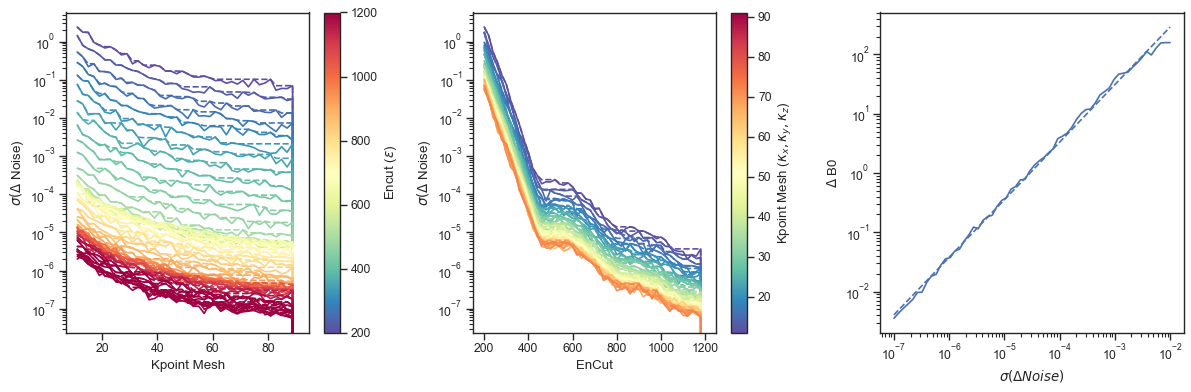

In [28]:
f, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=80)

vlen = len(kpoint_space)
for i, encut in enumerate(encut_space):
    std_lst = []
    for j, kpoint in enumerate(kpoint_space):
        ediff = np.array(eng_store_mat)[i][-1]-np.array(eng_store_mat)[i][j]-(np.array(eng_store_mat)[-1][-1]-np.array(eng_store_mat)[-1][j])
        std_lst.append(np.std([v for v in ediff if not np.isnan(v)]))
    axs[0].plot(kpoint_space, std_lst, color=cmap(i/vlen))
    axs[0].plot(kpoint_space, shift_lst(std_lst), "--", color=cmap(i/vlen))
axs[0].set_xlabel("Kpoint Mesh")
axs[0].set_ylabel("$\sigma(\Delta$ Noise)")
axs[0].set_yscale("log")
normalize = mcolors.Normalize(vmin=encut_space.min(), vmax=encut_space.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(encut_space)
cbar = f.colorbar(scalarmappaple, ax=axs[0])
cbar.set_label("Encut ($\epsilon$)")

vlen = len(encut_space)
for j, kpoint in enumerate(kpoint_space):
    std_lst = []
    for i, encut in enumerate(encut_space):
        ediff = np.array(eng_store_mat)[-1][j]-np.array(eng_store_mat)[i][j]-(np.array(eng_store_mat)[-1][-1]-np.array(eng_store_mat)[i][-1])
        std_lst.append(np.std([v for v in ediff if not np.isnan(v)]))
    axs[1].plot(encut_space, std_lst, color=cmap(j/vlen))
    axs[1].plot(encut_space, shift_lst(std_lst), "--", color=cmap(j/vlen))
axs[1].set_xlabel("EnCut")
axs[1].set_ylabel("$\sigma(\Delta$ Noise)")
axs[1].set_yscale("log")
normalize = mcolors.Normalize(vmin=kpoint_space.min(), vmax=kpoint_space.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(kpoint_space)
cbar = f.colorbar(scalarmappaple, ax=axs[1])
cbar.set_label("Kpoint Mesh ($\kappa_{x}, \kappa_{y}, \kappa_{z}$)")

degree = 13
fit_base = np.poly1d(np.polyfit(vol_space, eng_store_mat[-1][-1], degree))
geo_range = np.geomspace(10 ** -7, 10 ** -2, 60)
b0_noise_lst = []
for ediff_tmp in geo_range:
    b0_tmp_lst = []
    for i in range(100):
        eng_test = fit_base(vol_space) + np.random.normal(loc=0.0, scale=ediff_tmp, size=len(vol_space))
        fit_tmp = np.poly1d(np.polyfit(vol_space, eng_test, degree))
        v0_tmp = calc_v0_from_fit_funct(fit_funct=fit_tmp, x=vol_space)
        b0_tmp = bulk_modulus_from_fit_and_volume(fit_funct=fit_tmp, v_0=v0_tmp, convert_to_gpa=True)
        b0_tmp_lst.append(b0_tmp)
    b0_noise_lst.append(np.std(np.array(b0_tmp_lst)[~np.isnan(b0_tmp_lst)]))
fit_b0_noise = np.polyfit(np.log(geo_range[~np.isnan(b0_noise_lst)]), np.log(np.array(b0_noise_lst)[~np.isnan(b0_noise_lst)]), 1)
y_calc = np.exp(np.poly1d(fit_b0_noise)(np.log(geo_range)))


axs[2].plot(geo_range, b0_noise_lst, "-", color="C0")
axs[2].plot(geo_range, y_calc, "--", color="C0")
axs[2].set_xlabel("$\sigma(\Delta Noise)$")
axs[2].set_ylabel("$\Delta$ B0")
axs[2].set_yscale("log")
axs[2].set_xscale("log")

plt.tight_layout()

In [29]:
kpoint_recommended = 11
kpoint_min = np.min(np.arange(len(kpoint_space))[kpoint_recommended < kpoint_space])

In [30]:
encut_space[encut_min]

400.0

In [31]:
b0_level = 1
e0_level = np.max(geo_range[y_calc<b0_level])
e0_level, np.sqrt(e0_level)

(2.868316813342009e-05, 0.005355666917706897)

# Max Max Reconstruction

In [32]:
eng_max_max_lst, eng_max_max_noise_lst = [], []
for i, encut in enumerate(encut_space):
    for j, kpoint in enumerate(kpoint_space):
        eng = np.array(eng_store_mat[-1][j]) - np.array(eng_store_mat[i][j]) - np.array(eng_store_mat[-1][-1]) + np.array(eng_store_mat[i][-1])
        eng_max_max_noise_lst.append(np.std([en for en in eng if not np.isnan(en)]))
        eng = eng_store_mat[-1][-1]-(eng_store_mat[-1][-1]-np.array(eng_store_mat)[-1][j])-(eng_store_mat[-1][-1]-np.array(eng_store_mat)[i][-1])
        eng_max_max_lst.append(eng)

In [33]:
eng_max_max_mat = np.array(eng_max_max_lst, dtype=float).reshape(len(encut_space), len(kpoint_space), len(vol_space))
eng_max_max_noise_mat = np.array(eng_max_max_noise_lst, dtype=float).reshape(len(encut_space), len(kpoint_space))

In [34]:
v0_max_lst, b0_max_lst, bp_max_lst = [], [], []
v0_max_std_lst, b0_max_std_lst, bp_max_std_lst = [], [], []
for e, eng_lst, noise_lst in zip(encut_space, eng_max_max_mat, eng_max_max_noise_mat):
    for k, eng, noise_std in zip(kpoint_space, eng_lst, noise_lst):
        vol_lst, eng_lst = np.array([[vo, en] for vo, en in zip(vol_space, eng) if not np.isnan(en)]).T
        fit = np.poly1d(np.polyfit(vol_lst, eng_lst, degree))
        v0_tmp = calc_v0_from_fit_funct(fit_funct=fit, x=vol_space)
        b0_tmp = bulk_modulus_from_fit_and_volume(fit_funct=fit, v_0=v0_tmp, convert_to_gpa=True)
        bp_tmp = bulk_modulus_dereivative_from_fit_and_volume(fit_funct=fit, v_0=v0_tmp)
        v0_max_lst.append(v0_tmp)
        b0_max_lst.append(b0_tmp)
        bp_max_lst.append(bp_tmp)
        v0_tmp_lst, b0_tmp_lst, bp_tmp_lst = [], [], []
        for i in range(100):
            eng_test = fit(vol_space) + np.random.normal(loc=0.0, scale=noise_std, size=len(vol_space))
            fit_tmp = np.poly1d(np.polyfit(vol_space, eng_test, degree))
            v0_tmp = calc_v0_from_fit_funct(fit_funct=fit_tmp, x=vol_space)
            b0_tmp = bulk_modulus_from_fit_and_volume(fit_funct=fit_tmp, v_0=v0_tmp, convert_to_gpa=True)
            bp_tmp = bulk_modulus_dereivative_from_fit_and_volume(fit_funct=fit_tmp, v_0=v0_tmp)
            v0_tmp_lst.append(v0_tmp)
            b0_tmp_lst.append(b0_tmp)
            bp_tmp_lst.append(bp_tmp)
        v0_max_std_lst.append(np.std(v0_tmp_lst))
        b0_max_std_lst.append(np.std(b0_tmp_lst))
        bp_max_std_lst.append(np.std(bp_tmp_lst))
v0_max_mat = np.array(v0_max_lst).reshape(len(encut_space), len(kpoint_space))
b0_max_mat = np.array(b0_max_lst).reshape(len(encut_space), len(kpoint_space))
bp_max_mat = np.array(bp_max_lst).reshape(len(encut_space), len(kpoint_space))
v0_max_std_mat = np.array(v0_max_std_lst).reshape(len(encut_space), len(kpoint_space))
b0_max_std_mat = np.array(b0_max_std_lst).reshape(len(encut_space), len(kpoint_space))
bp_max_std_mat = np.array(bp_max_std_lst).reshape(len(encut_space), len(kpoint_space))

In [35]:
v0_raw_lst, b0_raw_lst, bp_raw_lst = [], [], []
for e, eng_lst in zip(encut_space, eng_store_mat):
    for k, eng in zip(kpoint_space, eng_lst):
        vol_lst, eng_lst = np.array([[vo, en] for vo, en in zip(vol_space, eng) if not np.isnan(en)]).T
        fit = np.poly1d(np.polyfit(vol_lst, eng_lst, degree))
        v0_tmp = calc_v0_from_fit_funct(fit_funct=fit, x=vol_space)
        b0_tmp = bulk_modulus_from_fit_and_volume(fit_funct=fit, v_0=v0_tmp, convert_to_gpa=True)
        bp_tmp = bulk_modulus_dereivative_from_fit_and_volume(fit_funct=fit, v_0=v0_tmp)
        v0_raw_lst.append(v0_tmp)
        b0_raw_lst.append(b0_tmp)
        bp_raw_lst.append(bp_tmp)
v0_raw_mat = np.array(v0_raw_lst).reshape(len(encut_space), len(kpoint_space))
b0_raw_mat = np.array(b0_raw_lst).reshape(len(encut_space), len(kpoint_space))
bp_raw_mat = np.array(bp_raw_lst).reshape(len(encut_space), len(kpoint_space))

In [36]:
b0_max_diff_mat = double_smooth(np.abs(b0_max_mat-b0_max_mat[-1,-1]))
b0_raw_diff_mat = double_smooth(np.abs(b0_raw_mat-b0_raw_mat[-1,-1]))

In [37]:
kpoint_mesh, encut_mesh = np.meshgrid(kpoint_space, encut_space)

/var/folders/ts/9tzhl05d4gbc4ymttnqmrhvh0000gn/T/ipykernel_66567/1904218804.py:18: UserWarning: Log scale: values of z <= 0 have been masked
  mappable = axs[1].contourf(kpoint_mesh, encut_mesh, b0_max_diff_mat, vmin=np.min(levels), vmax=np.max(levels), levels=levels, norm=mcolors.LogNorm(), cmap="viridis")


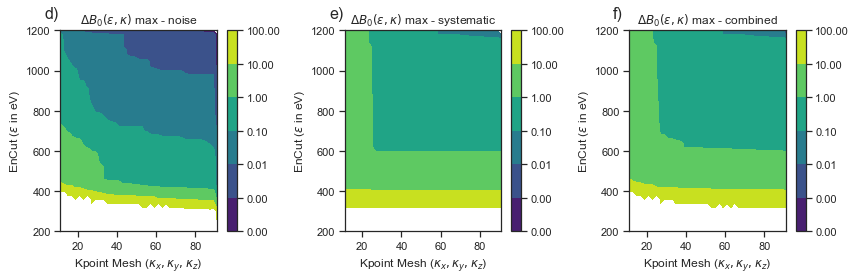

In [38]:
levels = np.geomspace(10 ** -4, 10 ** 2, 7)

f, axs = plt.subplots(1, 3, figsize=(12, 4))

import string
for n, ax in enumerate(axs.flatten()):
    ax.text(-0.1, 1.06, string.ascii_lowercase[n+3] + ")", transform=ax.transAxes, 
            size=16)

axs[0].set_title("$\Delta B_{0}(\epsilon, \kappa)$ max - noise")
mappable = axs[0].contourf(kpoint_mesh, encut_mesh, double_smooth(b0_max_std_mat), vmin=np.min(levels), vmax=np.max(levels), levels=levels, norm=mcolors.LogNorm(), cmap="viridis")
bar = f.colorbar(mappable, ax=axs[0])
cbar.set_label("$\Delta B_{0} (GPa)$")
axs[0].set_xlabel("Kpoint Mesh ($\kappa_{x}, \kappa_{y}, \kappa_{z}$)")
axs[0].set_ylabel("EnCut ($\epsilon$ in eV)")

axs[1].set_title("$\Delta B_{0}(\epsilon, \kappa)$ max - systematic")
mappable = axs[1].contourf(kpoint_mesh, encut_mesh, b0_max_diff_mat, vmin=np.min(levels), vmax=np.max(levels), levels=levels, norm=mcolors.LogNorm(), cmap="viridis")
bar = f.colorbar(mappable, ax=axs[1])
cbar.set_label("$\Delta B_{0} (GPa)$")
axs[1].set_xlabel("Kpoint Mesh ($\kappa_{x}, \kappa_{y}, \kappa_{z}$)")
axs[1].set_ylabel("EnCut ($\epsilon$ in eV)")

axs[2].set_title("$\Delta B_{0}(\epsilon, \kappa)$ max - combined")
mappable = axs[2].contourf(kpoint_mesh, encut_mesh, double_smooth(b0_max_diff_mat + b0_max_std_mat), vmin=np.min(levels), vmax=np.max(levels), levels=levels, norm=mcolors.LogNorm(), cmap="viridis")
bar = f.colorbar(mappable, ax=axs[2])
cbar.set_label("$\Delta B_{0} (GPa)$")
axs[2].set_xlabel("Kpoint Mesh ($\kappa_{x}, \kappa_{y}, \kappa_{z}$)")
axs[2].set_ylabel("EnCut ($\epsilon$ in eV)")

f.tight_layout()
plt.show()

# Singular Value Decomposition 

In [39]:
encut_ind = encut_space >= 0
kpoint_ind = kpoint_space >= 0

In [40]:
kmesh_ind, emesh_ind = np.meshgrid(kpoint_ind, encut_ind)

In [41]:
combined_ind = kmesh_ind* emesh_ind

In [42]:
b0_raw_mat[np.isnan(b0_raw_mat)] = 0.0

In [43]:
b0_red_mat = b0_raw_mat[combined_ind].reshape(sum(encut_ind), sum(kpoint_ind))

In [44]:
u, s, vh = linalg.svd(b0_red_mat, full_matrices=False)

In [45]:
encut_ind_n = encut_space >= encut_recommended
kpoint_ind_n = kpoint_space >= kpoint_recommended
kmesh_ind_n, emesh_ind_n = np.meshgrid(kpoint_ind_n, encut_ind_n)
combined_ind_n = kmesh_ind_n* emesh_ind_n
b0_red_mat_n = b0_raw_mat[combined_ind_n].reshape(sum(encut_ind_n), sum(kpoint_ind_n))
un, sn, vhn = linalg.svd(b0_red_mat_n, full_matrices=False)

In [46]:
encut_ind_v = encut_space >= 400
kpoint_ind_v = kpoint_space >= 21
kmesh_ind_v, emesh_ind_v = np.meshgrid(kpoint_ind_v, encut_ind_v)
combined_ind_v = kmesh_ind_v* emesh_ind_v
b0_red_mat_v = b0_raw_mat[combined_ind_v].reshape(sum(encut_ind_v), sum(kpoint_ind_v))
uv, sv, vhv = linalg.svd(b0_red_mat_v, full_matrices=False)

In [47]:
encut_ind_c = encut_space >= 600
kpoint_ind_c = kpoint_space >= 41
kmesh_ind_c, emesh_ind_c = np.meshgrid(kpoint_ind_c, encut_ind_c)
combined_ind_c = kmesh_ind_c* emesh_ind_c
b0_red_mat_c = b0_raw_mat[combined_ind_c].reshape(sum(encut_ind_c), sum(kpoint_ind_c))
uc, sc, vhc = linalg.svd(b0_red_mat_c, full_matrices=False)

/var/folders/ts/9tzhl05d4gbc4ymttnqmrhvh0000gn/T/ipykernel_66567/1894280365.py:3: UserWarning: Log scale: values of z <= 0 have been masked
  mappable = axs[0].contourf(kpoint_mesh, encut_mesh, np.abs(b0_red_mat-b0_red_mat[-1,-1]), vmin=np.min(levels), vmax=np.max(levels), levels=levels, norm=mcolors.LogNorm(), cmap="viridis")
/var/folders/ts/9tzhl05d4gbc4ymttnqmrhvh0000gn/T/ipykernel_66567/1894280365.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  mappable = axs[1].contourf(kpoint_mesh, encut_mesh, double_smooth(np.abs(b0_red_mat-b0_red_mat[-1,-1])), vmin=np.min(levels), vmax=np.max(levels), levels=levels, norm=mcolors.LogNorm(), cmap="viridis")


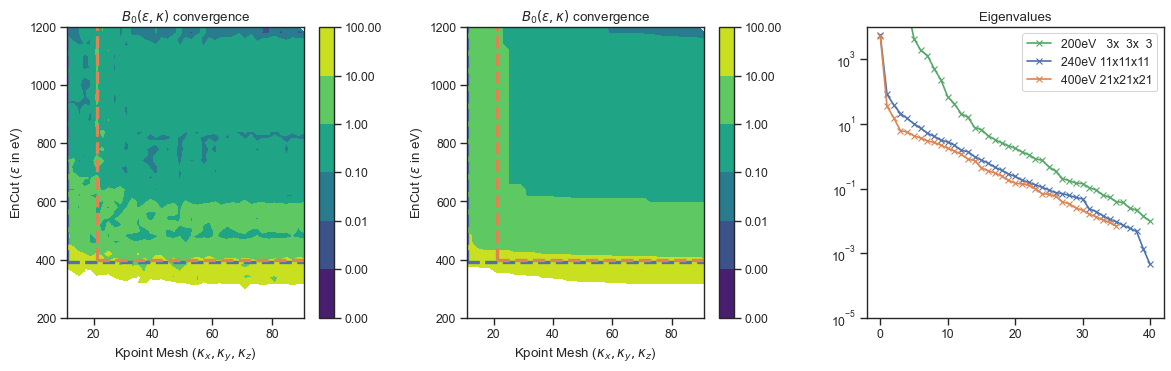

In [48]:
f, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=80)
axs[0].set_title("$B_{0}(\epsilon, \kappa)$ convergence")
mappable = axs[0].contourf(kpoint_mesh, encut_mesh, np.abs(b0_red_mat-b0_red_mat[-1,-1]), vmin=np.min(levels), vmax=np.max(levels), levels=levels, norm=mcolors.LogNorm(), cmap="viridis")
axs[0].plot([11, 91], [encut_recommended, encut_recommended], "--", color="C0", linewidth=3)
axs[0].plot([11, 11], [encut_recommended, encut_space[-1]], "--", color="C0", linewidth=3)
axs[0].plot([21, 91], [400, 400], "--", color="C1", linewidth=3)
axs[0].plot([21, 21], [400, encut_space[-1]], "--", color="C1", linewidth=3)
bar = f.colorbar(mappable, ax=axs[0])
cbar.set_label("$\Delta B_{0} (GPa)$")
axs[0].set_xlabel("Kpoint Mesh ($\kappa_{x}, \kappa_{y}, \kappa_{z}$)")
axs[0].set_ylabel("EnCut ($\epsilon$ in eV)")
axs[1].set_title("$B_{0}(\epsilon, \kappa)$ convergence")
mappable = axs[1].contourf(kpoint_mesh, encut_mesh, double_smooth(np.abs(b0_red_mat-b0_red_mat[-1,-1])), vmin=np.min(levels), vmax=np.max(levels), levels=levels, norm=mcolors.LogNorm(), cmap="viridis")
axs[1].plot([11, 91], [encut_recommended, encut_recommended], "--", color="C0", linewidth=3)
axs[1].plot([11, 11], [encut_recommended, encut_space[-1]], "--", color="C0", linewidth=3)
axs[1].plot([21, 91], [400, 400], "--", color="C1", linewidth=3)
axs[1].plot([21, 21], [400, encut_space[-1]], "--", color="C1", linewidth=3)
# axs[0].plot([41, 91], [600, 600], "--", color="C2", linewidth=3)
# axs[0].plot([41, 41], [600, encut_space[-1]], "--", color="C2", linewidth=3)
bar = f.colorbar(mappable, ax=axs[1])
cbar.set_label("$\Delta B_{0} (GPa)$")
axs[1].set_xlabel("Kpoint Mesh ($\kappa_{x}, \kappa_{y}, \kappa_{z}$)")
axs[1].set_ylabel("EnCut ($\epsilon$ in eV)")
axs[2].set_title("Eigenvalues")
axs[2].plot(s, 'x-', color="C2", label="200eV   3x  3x  3")
axs[2].plot(sn, 'x-', color="C0", label="240eV 11x11x11")
axs[2].plot(sv, 'x-', color="C1", label="400eV 21x21x21")
axs[2].set_yscale("log")
axs[2].set_ylim(10**-5, 10**4)
axs[2].legend()
f.tight_layout(pad=2.0)
# f.savefig("svd1.png")

In [49]:
encut_ind = encut_space > encut_recommended
kpoint_ind = kpoint_space > kpoint_recommended
kmesh_ind, emesh_ind = np.meshgrid(kpoint_ind, encut_ind)
combined_ind = kmesh_ind* emesh_ind
b0_red_mat = b0_raw_mat[combined_ind].reshape(sum(encut_ind), sum(kpoint_ind))
u, s, vh = linalg.svd(b0_red_mat, full_matrices=False)

In [50]:
s_first = np.array([0] * len(s))
s_first[0] = s[0]

In [51]:
np.dot(u * s_first, vh)

array([[153.04360844, 152.88540011, 152.2312644 , ..., 151.97024599,
        152.08710279, 152.00375169],
       [147.02335036, 146.87136545, 146.2429614 , ..., 145.99221064,
        146.10447066, 146.02439833],
       [144.88064964, 144.73087974, 144.11163397, ..., 143.86453763,
        143.97516158, 143.89625622],
       ...,
       [141.27779611, 141.13175065, 140.52790412, ..., 140.2869525 ,
        140.39482549, 140.31788232],
       [141.37532167, 141.22917539, 140.62491202, ..., 140.38379407,
        140.49174153, 140.41474524],
       [141.38631591, 141.24015827, 140.63584791, ..., 140.39471121,
        140.50266705, 140.42566478]])

/var/folders/ts/9tzhl05d4gbc4ymttnqmrhvh0000gn/T/ipykernel_66567/3848438440.py:23: UserWarning: Log scale: values of z <= 0 have been masked
  mappable = axs[2].contourf(kpoint_mesh[combined_ind].reshape(sum(encut_ind), sum(kpoint_ind)), encut_mesh[combined_ind].reshape(sum(encut_ind), sum(kpoint_ind)), np.abs(np.dot(u * s_first, vh)-np.dot(u * s_first, vh)[-1,-1]), vmin=np.min(levels), vmax=np.max(levels), levels=levels, norm=mcolors.LogNorm(), cmap="viridis")


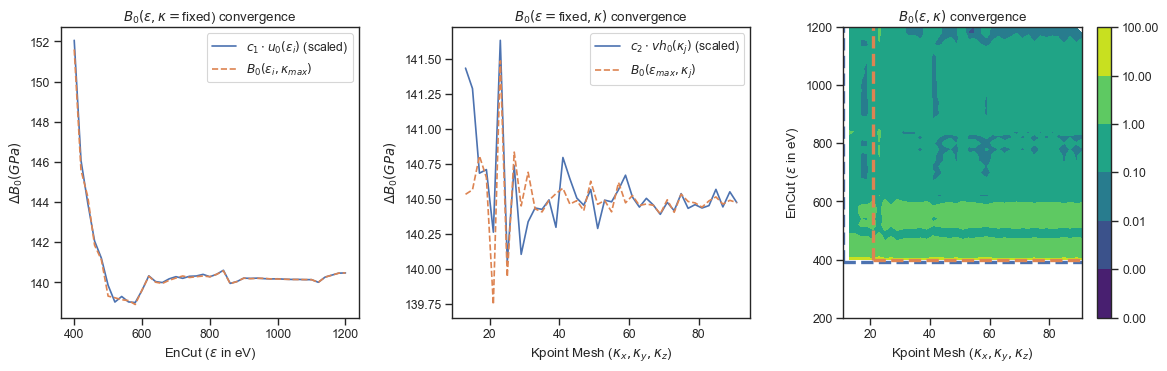

In [52]:
f, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=80)
axs[0].set_title("$B_{0}(\epsilon, \kappa =$fixed) convergence")
for i, [u_tmp, s_tmp] in enumerate(zip(u.T[:1],s)):
    shift = -s_tmp*u_tmp[-1] / np.array(b0_red_mat)[-1][-1]
    axs[0].plot(encut_space[encut_ind], -s_tmp/shift * u_tmp, label="$c_1 \cdot u_{" + str(i) + "}(\epsilon_{i})$ (scaled)", color="C0")
# axs[0].plot(encut_space[encut_ind], np.array(b0_red_mat).T[0] + np.array(b0_red_mat).T[-1][-1] - np.array(b0_red_mat).T[0][-1], "--", label="$B_{0}(\epsilon_{i}, \kappa_{min})$ (shift)")
axs[0].plot(encut_space[encut_ind], np.array(b0_red_mat).T[-1], "--", label="$B_{0}(\epsilon_{i}, \kappa_{max})$", color="C1")
axs[0].legend()
axs[0].set_xlabel("EnCut ($\epsilon$ in eV)")
axs[0].set_ylabel("$\Delta B_{0} (GPa)$")

axs[1].set_title("$B_{0}(\epsilon=$fixed$, \kappa)$ convergence")
for i, [vh_tmp, s_tmp] in enumerate(zip(vh[:1], s)):
    shift = -s_tmp*vh_tmp[-1] / np.array(b0_red_mat)[-1][-1]
    axs[1].plot(kpoint_space[kpoint_ind], -s_tmp/shift*vh_tmp, label="$c_2 \cdot vh_{" + str(i) + "}(\kappa_{j})$ (scaled)", color="C0")
# axs[1].plot(kpoint_space[kpoint_ind], np.array(b0_red_mat)[0] + np.array(b0_red_mat)[-1][-1]-np.array(b0_red_mat)[0][-1], "--", label="$B_{0}(\epsilon_{min}, \kappa_{j})$ (shift)")
axs[1].plot(kpoint_space[kpoint_ind], np.array(b0_red_mat)[-1], "--", label="$B_{0}(\epsilon_{max}, \kappa_{j})$", color="C1")
axs[1].legend()
axs[1].set_xlabel("Kpoint Mesh ($\kappa_{x}, \kappa_{y}, \kappa_{z}$)")
axs[1].set_ylabel("$\Delta B_{0} (GPa)$")

axs[2].set_title("$B_{0}(\epsilon, \kappa)$ convergence")
mappable = axs[2].contourf(kpoint_mesh[combined_ind].reshape(sum(encut_ind), sum(kpoint_ind)), encut_mesh[combined_ind].reshape(sum(encut_ind), sum(kpoint_ind)), np.abs(np.dot(u * s_first, vh)-np.dot(u * s_first, vh)[-1,-1]), vmin=np.min(levels), vmax=np.max(levels), levels=levels, norm=mcolors.LogNorm(), cmap="viridis")
axs[2].plot([11, 91], [encut_recommended, encut_recommended], "--", color="C0", linewidth=3)
axs[2].plot([11, 11], [encut_recommended, encut_space[-1]], "--", color="C0", linewidth=3)
axs[2].plot([21, 91], [400, 400], "--", color="C1", linewidth=3)
axs[2].plot([21, 21], [400, encut_space[-1]], "--", color="C1", linewidth=3)
bar = f.colorbar(mappable, ax=axs[2])
cbar.set_label("$\Delta B_{0} (GPa)$")
axs[2].set_xlabel("Kpoint Mesh ($\kappa_{x}, \kappa_{y}, \kappa_{z}$)")
axs[2].set_ylabel("EnCut ($\epsilon$ in eV)")
axs[2].set_xlim(np.min(kpoint_space), np.max(kpoint_space))
axs[2].set_ylim(np.min(encut_space), np.max(encut_space))
f.tight_layout(pad=2.0)

# Energy Differences

In [53]:
kpoint_min_tmp = 2

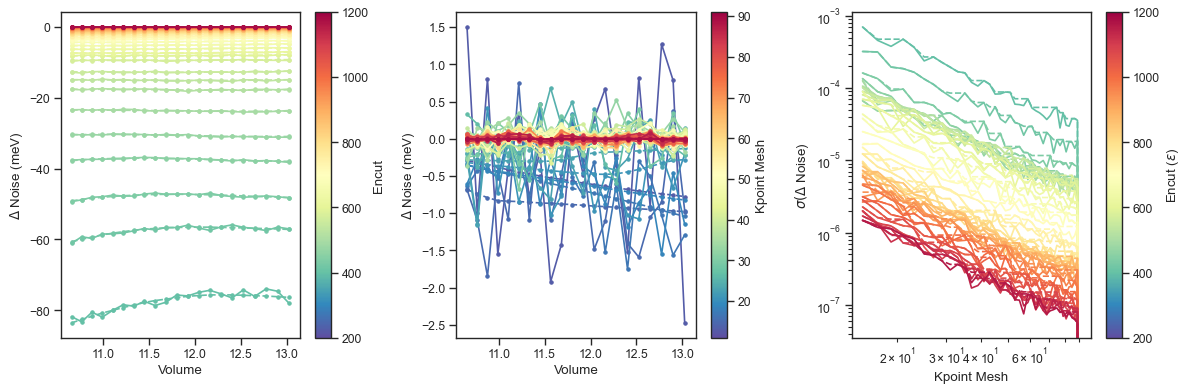

In [54]:
f, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=80)
vlen = len(encut_space)
for i, encut in enumerate(encut_space[encut_min:]):
    ediff_low = np.array(eng_store_mat[-1][kpoint_min]) - np.array(eng_store_mat[encut_min+i][kpoint_min])
    ediff_high = np.array(eng_store_mat[-1][-1]) - np.array(eng_store_mat[encut_min+i][-1])
    axs[0].plot(vol_space, ediff_low * 1000, ".-", color=cmap((i+encut_min)/vlen))
    axs[0].plot(vol_space, ediff_high * 1000, ".--", color=cmap((i+encut_min)/vlen))
vlen = len(kpoint_space)
for j, kpoint in enumerate(kpoint_space[kpoint_min:]):
    ediff_low = np.array(eng_store_mat[encut_min][-1]) - np.array(eng_store_mat[encut_min][kpoint_min+j])
    ediff_high = np.array(eng_store_mat[-1][-1]) - np.array(eng_store_mat[-1][kpoint_min+j])
    axs[1].plot(vol_space, ediff_low * 1000, ".-",color=cmap((j+kpoint_min)/vlen))
    axs[1].plot(vol_space, ediff_high * 1000, ".--", color=cmap((j+kpoint_min)/vlen))
axs[0].set_xlabel("Volume")
axs[0].set_ylabel("$\Delta$ Noise (meV)")
axs[1].set_xlabel("Volume")
axs[1].set_ylabel("$\Delta$ Noise (meV)")
normalize = mcolors.Normalize(vmin=encut_space.min(), vmax=encut_space.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(encut_space)
cbar = f.colorbar(scalarmappaple, ax=axs[0])
cbar.set_label("Encut")
normalize = mcolors.Normalize(vmin=kpoint_space.min(), vmax=kpoint_space.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(kpoint_space)
cbar = f.colorbar(scalarmappaple, ax=axs[1])
cbar.set_label("Kpoint Mesh")

vlen = len(encut_space)
for i, encut in enumerate(encut_space[encut_min:]):
    std_lst = []
    for j, kpoint in enumerate(kpoint_space[kpoint_min_tmp:]):
        ediff = np.array(eng_store_mat)[i+encut_min][-1]-np.array(eng_store_mat)[i+encut_min][j+kpoint_min_tmp]-(np.array(eng_store_mat)[-1][-1]-np.array(eng_store_mat)[-1][j+kpoint_min_tmp])
        std_lst.append(np.std([v for v in ediff if not np.isnan(v)]))
    axs[2].plot(kpoint_space[kpoint_min_tmp:], std_lst, color=cmap((i+encut_min)/vlen))
    axs[2].plot(kpoint_space[kpoint_min_tmp:], shift_lst(std_lst), "--", color=cmap((i+encut_min)/vlen))
axs[2].set_xlabel("Kpoint Mesh")
axs[2].set_ylabel("$\sigma(\Delta$ Noise)")
axs[2].set_yscale("log")
axs[2].set_xscale("log")
normalize = mcolors.Normalize(vmin=encut_space.min(), vmax=encut_space.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(encut_space)
cbar = f.colorbar(scalarmappaple, ax=axs[2])
cbar.set_label("Encut ($\epsilon$)")

plt.tight_layout()
plt.show()